In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline

In [2]:
# wells were grouped on 2 plates which were captured with different settings on the celigo
# this leads to different GFP backgrounds.

# Also the control column (11) is setup differently on the 2 plates so its mostly only useful as a indication of what normal viability should be


# Procedue:
# I go over each plate 1 at a time and then combine them into a final dataframe for visualizations

In [3]:
plate2 = pd.read_csv("celigo_object_level_export/FreestyleMax FectoCHO Transfection efficiency_Scan_22-03-19-2-51-59-AM_Result_01-04-19-10-34-36-PM_objectlevel.csv", skiprows=16)

In [4]:
plate2.head()

,Well,Row,Column,Total,Class 1,Class 2,Class 3,Class 4,X Position (µm),Y Position (µm),Area (µm²),Form Factor,Smoothness,Aspect Ratio,Target 1: Mean Intensity,Target 1: Integrated Intensity,Target 2: Mean Intensity,Target 2: Integrated Intensity,Mask: Mean Intensity,Mask: Integrated Intensity
0,A2,A,2,True,False,False,False,False,-2833.732422,-1267.719727,25.615131,0.543003,0.942041,0.285725,66.956520,1540.0,161.347824,3711.0,27.000000,621
1,A2,A,2,True,False,False,False,False,-3132.696777,-802.943848,18.932922,0.809740,0.949676,1.000000,61.823528,1051.0,64.941177,1104.0,25.647058,436
2,A2,A,2,True,False,False,False,False,-3255.318115,-309.234192,49.002861,0.543369,0.925362,0.286072,69.159088,3043.0,NaN,NaN,22.431818,987
3,A2,A,2,True,False,False,False,False,-3253.179932,-299.820557,25.615131,0.748014,0.942927,0.641804,67.608696,1555.0,NaN,NaN,23.086956,531
4,A2,A,2,True,False,False,False,False,-3239.995361,-320.151978,32.297340,0.468183,0.934377,0.222849,72.206894,2094.0,132.344833,3838.0,21.448277,622


In [5]:
def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

In [6]:
cells_counts = plate2.pivot_table(index='Row', columns='Column', values='Total', aggfunc=len)
cells_counts.style.apply(background_gradient, cmap=colors.ListedColormap(sns.color_palette("RdYlGn", 10, desat=.75)), m=0, M=5000, low=0, high=0.2)

/home/laeb/.pyenv/versions/3.7.2/envs/scipy/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Column,2,3,4,5,6,7,8,9,10,11
Row,,,,,,,,,,
A,3926,4506,5605,8331,8253,6511,5617,5554,6002,12292
B,5808,6909,7082,7736,8659,7415,5016,5540,4571,12205
C,3285,2822,2796,3969,3074,1612,1780,1882,1392,5980
D,2772,1637,1327,1339,712,660,778,655,538,2186
E,177,119,149,142,192,276,340,352,342,5
F,1334,567,784,280,497,684,838,762,619,2
G,823,579,349,354,495,451,1077,559,708,8
H,1953,1279,561,466,546,651,714,570,659,nan


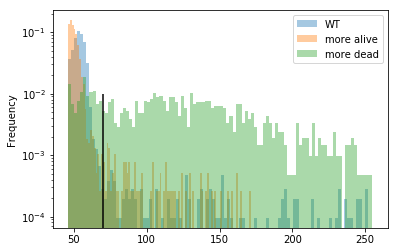

In [79]:
plate2[(plate2['Row']=="C") & (plate2['Column']==11)]['Target 1: Mean Intensity'].plot(kind='hist', bins=100, alpha=0.4, density=True, logy=True, label='WT')
plate2[(plate2['Row']=="B") & (plate2['Column']==10)]['Target 1: Mean Intensity'].plot(kind='hist', bins=100, alpha=0.4, density=True, logy=True, label="more alive")
plate2[(plate2['Row']=="G") & (plate2['Column']==8)]['Target 1: Mean Intensity'].plot(kind='hist', bins=100, alpha=0.4, density=True, logy=True, label="more dead")
plt.vlines(70, 0, 0.01)
plt.legend()

In [14]:
# target 1 is dead cells (PI stain)
alive_threshold = 70
viability = []
for row in plate2['Row'].unique():
    for col in plate2['Column'].unique():
        alive = plate2[(plate2['Row']==row) & (plate2['Column']==col)]['Target 1: Mean Intensity'].fillna(0) < alive_threshold
        viability.append({'row':row, 'col':col,'via': alive.sum()/len(alive)})
viability = pd.DataFrame(viability).pivot_table(index='row', columns='col', values='via')
viability.style.apply(background_gradient, cmap=colors.ListedColormap(sns.color_palette("RdYlGn", 10, desat=.75)), m=0, M=1, low=0, high=0.2).format("{:.0%}")

/home/laeb/.pyenv/versions/3.7.2/envs/scipy/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


col,2,3,4,5,6,7,8,9,10,11
row,,,,,,,,,,
A,28%,56%,74%,89%,91%,91%,97%,97%,98%,97%
B,70%,79%,84%,93%,93%,95%,98%,98%,98%,91%
C,74%,78%,83%,91%,92%,90%,97%,97%,97%,98%
D,79%,82%,84%,91%,86%,90%,96%,93%,93%,99%
E,45%,66%,58%,47%,31%,47%,28%,37%,37%,80%
F,76%,77%,87%,48%,56%,73%,33%,30%,31%,100%
G,17%,84%,85%,51%,80%,66%,29%,49%,46%,100%
H,82%,86%,84%,41%,77%,68%,19%,30%,25%,nan%


In [18]:
#alternative way of showing cell death
death_glow = plate2.pivot_table(index='Row', columns='Column', values='Target 1: Mean Intensity', aggfunc='mean')
death_glow = death_glow-death_glow.min().min()
death_glow.style.apply(background_gradient, cmap=colors.ListedColormap(sns.color_palette("RdYlGn_r", 10, desat=.75)), m=0, M=75, low=0, high=0.2).format("{:.0f}")

Column,2,3,4,5,6,7,8,9,10,11
Row,,,,,,,,,,
A,38,30,25,13,10,9,3,2,0,3
B,25,21,16,9,9,4,1,1,0,7
C,26,23,17,11,8,9,2,2,2,4
D,23,22,18,11,15,11,5,9,11,3
E,70,52,55,61,78,89,123,120,101,105
F,27,27,17,57,47,30,72,61,58,nan
G,65,20,23,60,30,47,66,50,54,nan
H,25,18,23,71,29,39,69,62,62,nan


In [23]:
# target 2 is gfp
background_threshold = 0
gfp = []
for row in plate2['Row'].unique():
    for col in plate2['Column'].unique():
        gfp_positive = plate2[(plate2['Row']==row) & (plate2['Column']==col)]['Target 2: Mean Intensity'].fillna(0) > background_threshold
        gfp.append({'row':row, 'col':col,'gfp_pos': gfp_positive.sum()/len(gfp_positive)})
gfp = pd.DataFrame(gfp).pivot_table(index='row', columns='col', values='gfp_pos')
gfp.style.apply(background_gradient, cmap=colors.ListedColormap(sns.color_palette("RdYlGn", 10, desat=.75)), m=0, M=0.5, low=0, high=0.2).format("{:.0%}")

/home/laeb/.pyenv/versions/3.7.2/envs/scipy/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


col,2,3,4,5,6,7,8,9,10,11
row,,,,,,,,,,
A,25%,25%,24%,17%,19%,17%,4%,4%,3%,0%
B,23%,26%,25%,13%,13%,14%,3%,4%,2%,0%
C,21%,21%,25%,17%,18%,19%,4%,3%,3%,0%
D,20%,24%,22%,16%,18%,15%,3%,2%,2%,0%
E,19%,11%,16%,25%,27%,22%,18%,22%,18%,0%
F,28%,26%,20%,23%,37%,41%,76%,70%,57%,0%
G,19%,16%,13%,24%,18%,34%,81%,28%,32%,0%
H,17%,19%,15%,23%,23%,33%,34%,41%,33%,nan%


In [24]:
# there is apparently zero gfp background so row 11 is gone
gfp_mean_glow = plate2.pivot_table(index='Row', columns='Column', values='Target 2: Mean Intensity', aggfunc='mean')
gfp_mean_glow.style.apply(background_gradient, cmap=colors.ListedColormap(sns.color_palette("RdYlGn", 10, desat=.75)), m=50, M=150, low=0, high=0.2).format("{:.0f}")

Column,2,3,4,5,6,7,8,9,10
Row,,,,,,,,,
A,145,143,137,139,136,144,158,147,150
B,141,142,142,139,140,141,137,135,135
C,153,159,161,155,159,169,157,143,137
D,158,170,168,151,171,160,164,147,181
E,131,164,140,140,153,111,92,97,124
F,130,120,135,139,112,132,98,100,103
G,115,137,125,135,135,139,98,137,133
H,141,132,133,142,143,138,114,113,111


In [25]:
# preparations for creating a nice long form dataset
cols = [x+2 for x in range(9)]
rows = ['A', 'B', 'C','D', 'E', 'F', 'G', 'H']

FM = ['A', 'B', 'C', 'D']
TR_lookup = {f"{row}{col}":'FM' if row in FM else 'FP' for row in rows for col in cols}
M1 = ['A', 'B', 'E', 'F']
media_lookup = {f"{row}{col}":'M1' if row in M1 else 'M2' for row in rows for col in cols}
D1 = ['A', 'C', 'E', 'G']
cell_density_lookup = {f"{row}{col}":'D1' if row in D1 else 'D2' for row in rows for col in cols}
pcl = {2:'P1', 3:'P1', 4:'P1', 5:'P2', 6:'P2', 7:'P2', 8:'P3', 9:'P3', 10:'P3'}
plasmid_concentration_lookup = {f"{row}{col}":pcl[col] for row in rows for col in cols}

In [27]:
# create a long form dataframe

alive_threshold = 70
gfp_threshold = 0
cell_count_threshold = 200

long_form = []
for row in rows:
    for col in cols:
        well = plate2[(plate2['Row'] == row) & (plate2['Column'] == col)]
        tox = well['Target 1: Mean Intensity'].fillna(0) < alive_threshold
        gfp = well['Target 2: Mean Intensity'].fillna(0) > gfp_threshold
        cell_count = len(plate2[plate2['Well'] == f"{row}{col}"])
        if cell_count > cell_count_threshold:
            long_form.append({
                'row':row,
                'col':col,
                'cell_count': cell_count,
                'media':media_lookup[f"{row}{col}"],
                'cell_density':cell_density_lookup[f"{row}{col}"],
                'plasmid_concentration':plasmid_concentration_lookup[f"{row}{col}"],
                'viability': tox.sum()/len(tox),
                'perc_trans': gfp.sum()/len(gfp),
                'mean_glow': gfp_mean_glow[col][row],
                'TR': TR_lookup[f"{row}{col}"]
            })
plate2_long_form = pd.DataFrame(long_form)

In [28]:
#second plate (which to make things easy is known as plate 1)
df = pd.read_csv("celigo_object_level_export/R007_PEI Transfection efficiency_Scan_22-03-19-2-29-38-AM_Result_22-03-19-3-20-34-AM_objectlevel.csv", skiprows=16)

In [29]:
cells_counts = df.pivot_table(index='Row', columns='Column', values='Total', aggfunc=len)
cells_counts.style.apply(background_gradient, cmap=colors.ListedColormap(sns.color_palette("RdYlGn", 10, desat=.75)), m=0, M=5000, low=0, high=0.2)

Column,2,3,4,5,6,7,8,9,10,11
Row,,,,,,,,,,
A,10,12,45,56,19,33,2038,1858,1934,2
B,27,76,53,199,89,237,2296,2981,4330,3
C,27,24,35,59,76,80,311,771,660,6
D,15,11,43,51,92,305,2307,2614,2411,6
E,17786,19180,17073,17260,18963,20703,17536,19719,16476,21578
F,23680,23535,27652,22479,24351,17177,20165,19750,23944,22741
G,13388,13430,14640,10291,10158,8963,8752,10040,9646,12803
H,17374,21766,22390,20820,16636,15151,16069,17423,16872,14557


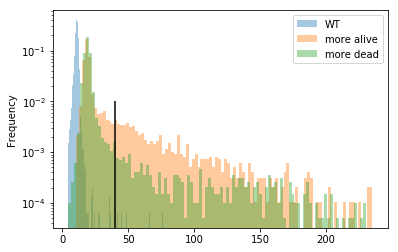

In [81]:
df[(df['Row']=="E") & (df['Column']==11)]['Target 1: Mean Intensity'].plot(kind='hist', bins=100, alpha=0.4, density=True, logy=True, label='WT')
df[(df['Row']=="B") & (df['Column']==10)]['Target 1: Mean Intensity'].plot(kind='hist', bins=100, alpha=0.4, density=True, logy=True, label="more alive")
df[(df['Row']=="G") & (df['Column']==8)]['Target 1: Mean Intensity'].plot(kind='hist', bins=100, alpha=0.4, density=True, logy=True, label="more dead")
plt.vlines(40, 0, 0.01)
plt.legend()

In [62]:
# target 1 is dead cells
alive_threshold = 40
viability = []
for row in df['Row'].unique():
    for col in df['Column'].unique():
        alive = df[(df['Row']==row) & (df['Column']==col)]['Target 1: Mean Intensity'].fillna(0) < alive_threshold #.plot(kind='hist', xlim=(0,250))
        viability.append({'row':row, 'col':col,'via': alive.sum()/len(alive)})
viability = pd.DataFrame(viability).pivot_table(index='row', columns='col', values='via')
viability.style.apply(background_gradient, cmap=colors.ListedColormap(sns.color_palette("RdYlGn", 10, desat=.75)), m=0, M=1, low=0, high=0.2).format("{:.0%}")

col,2,3,4,5,6,7,8,9,10,11
row,,,,,,,,,,
A,20%,67%,82%,80%,58%,82%,65%,80%,81%,100%
B,78%,86%,77%,57%,56%,39%,70%,84%,84%,33%
C,44%,54%,86%,86%,86%,60%,39%,59%,63%,17%
D,80%,100%,74%,45%,30%,21%,56%,67%,80%,50%
E,97%,98%,98%,98%,98%,97%,97%,96%,96%,100%
F,94%,97%,98%,98%,98%,91%,97%,96%,97%,100%
G,96%,98%,98%,97%,98%,97%,96%,97%,96%,100%
H,92%,96%,97%,97%,97%,97%,95%,96%,96%,100%


In [82]:
death_glow = df.pivot_table(index='Row', columns='Column', values='Target 1: Mean Intensity', aggfunc='mean')
death_glow = death_glow-death_glow.min().min()
death_glow.style.apply(background_gradient, cmap=colors.ListedColormap(sns.color_palette("RdYlGn_r", 10, desat=.75)), m=0, M=75, low=0, high=0.2).format("{:.0f}")

Column,2,3,4,5,6,7,8,9,10,11
Row,,,,,,,,,,
A,111,45,19,22,54,12,40,22,19,24
B,50,19,23,66,55,78,35,20,19,26
C,82,74,16,11,15,34,69,45,39,86
D,32,8,44,77,91,97,51,37,24,31
E,16,16,14,12,12,11,11,10,10,0
F,20,16,13,13,11,18,11,11,9,0
G,17,14,13,12,12,12,12,10,10,0
H,25,16,15,13,12,11,14,12,11,1


In [85]:
# target 2 is gfp
background_threshold = 24
gfp = []
for row in df['Row'].unique():
    for col in df['Column'].unique():
        gfp_positive = df[(df['Row']==row) & (df['Column']==col)]['Target 2: Mean Intensity'].fillna(0) > background_threshold
        gfp.append({'row':row, 'col':col,'gfp_pos': gfp_positive.sum()/len(gfp_positive)})
gfp = pd.DataFrame(gfp).pivot_table(index='row', columns='col', values='gfp_pos')
gfp.style.apply(background_gradient, cmap=colors.ListedColormap(sns.color_palette("RdYlGn", 10, desat=.75)), m=0, M=0.5, low=0, high=0.2).format("{:.0%}")

col,2,3,4,5,6,7,8,9,10,11
row,,,,,,,,,,
A,0%,0%,0%,0%,0%,6%,15%,23%,21%,0%
B,11%,5%,0%,15%,8%,14%,50%,53%,57%,0%
C,0%,12%,0%,0%,0%,0%,5%,10%,9%,17%
D,0%,0%,0%,4%,11%,3%,17%,29%,33%,0%
E,3%,3%,2%,19%,24%,24%,58%,61%,16%,0%
F,2%,2%,2%,16%,15%,96%,46%,75%,42%,0%
G,3%,2%,2%,12%,14%,11%,32%,28%,24%,0%
H,3%,2%,3%,18%,14%,12%,43%,47%,53%,0%


In [86]:
gfp_mean_glow = df.pivot_table(index='Row', columns='Column', values='Target 2: Mean Intensity', aggfunc='mean')
gfp_mean_glow.style.apply(background_gradient, cmap=colors.ListedColormap(sns.color_palette("RdYlGn", 10, desat=.75)), m=0, M=50, low=0, high=0.2).format("{:.0f}")

Column,2,3,4,5,6,7,8,9,10,11
Row,,,,,,,,,,
A,15,8,3,3,8,10,28,32,29,4
B,16,8,6,25,21,27,53,50,48,3
C,13,26,3,5,6,6,22,24,22,12
D,6,4,10,13,24,19,33,38,44,6
E,20,20,19,30,30,31,39,40,32,16
F,19,19,19,28,27,73,33,43,32,17
G,20,19,19,27,29,27,35,34,34,18
H,20,19,20,29,28,28,35,36,36,19


In [87]:
cols = [x+2 for x in range(9)]
rows = ['A', 'B', 'C','D', 'E', 'F', 'G', 'H']

R007 = ['A', 'B', 'C', 'D']
TR_lookup = {f"{row}{col}":'R007' if row in R007 else 'PP' for row in rows for col in cols}
M1 = ['A', 'B', 'E', 'F']
media_lookup = {f"{row}{col}":'M1' if row in M1 else 'M2' for row in rows for col in cols}
D1 = ['A', 'C', 'E', 'G']
cell_density_lookup = {f"{row}{col}":'D1' if row in D1 else 'D2' for row in rows for col in cols}
pcl = {2:'P1', 3:'P1', 4:'P1', 5:'P2', 6:'P2', 7:'P2', 8:'P3', 9:'P3', 10:'P3'}
plasmid_concentration_lookup = {f"{row}{col}":pcl[col] for row in rows for col in cols}



In [88]:
alive_threshold = 40
gfp_threshold = 24
cell_count_threshold = 200

#quality_filter = ['A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7']

long_form = []
for row in rows:
    for col in cols:
        well = df[(df['Row'] == row) & (df['Column'] == col)]
        tox = well['Target 1: Mean Intensity'].fillna(0) < alive_threshold
        gfp = well['Target 2: Mean Intensity'].fillna(0) > gfp_threshold
        cell_count = len(df[df['Well'] == f"{row}{col}"])
        if cell_count > cell_count_threshold:
            long_form.append({
                'row':row,
                'col':col,
                'media':media_lookup[f"{row}{col}"],
                'cell_count': cell_count,
                'cell_density':cell_density_lookup[f"{row}{col}"],
                'plasmid_concentration':plasmid_concentration_lookup[f"{row}{col}"],
                'viability': tox.sum()/len(tox),
                'perc_trans': gfp.sum()/len(gfp),
                'mean_glow': gfp_mean_glow[col][row],
                'TR': TR_lookup[f"{row}{col}"]
            })
plate1_long_form = pd.DataFrame(long_form)

In [89]:
long_form = pd.concat([plate1_long_form,plate2_long_form])

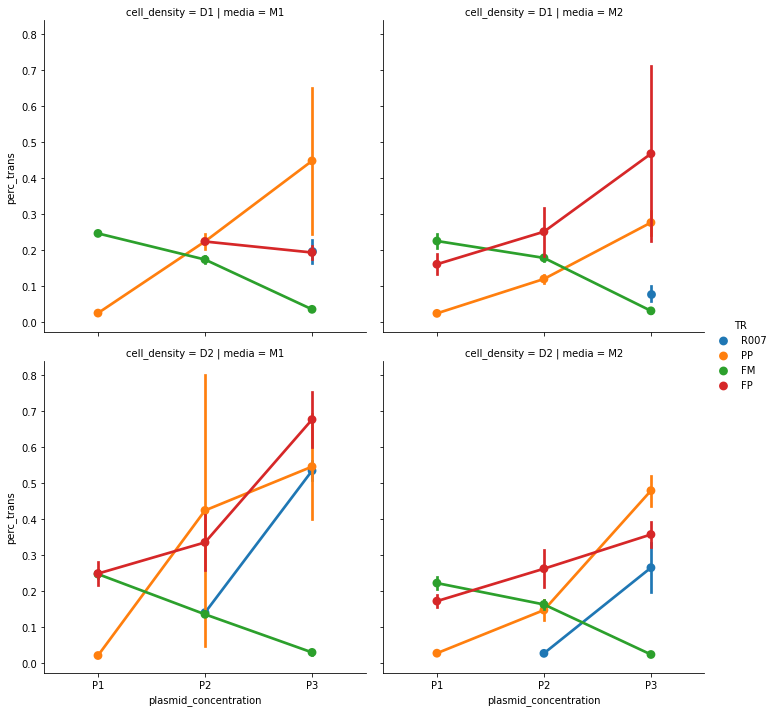

In [90]:
sns.catplot(data=long_form, x='plasmid_concentration', y='perc_trans', hue='TR', row='cell_density', col='media', ci='sd', n_boot=1000, kind='point', order=['P1', 'P2', 'P3'])

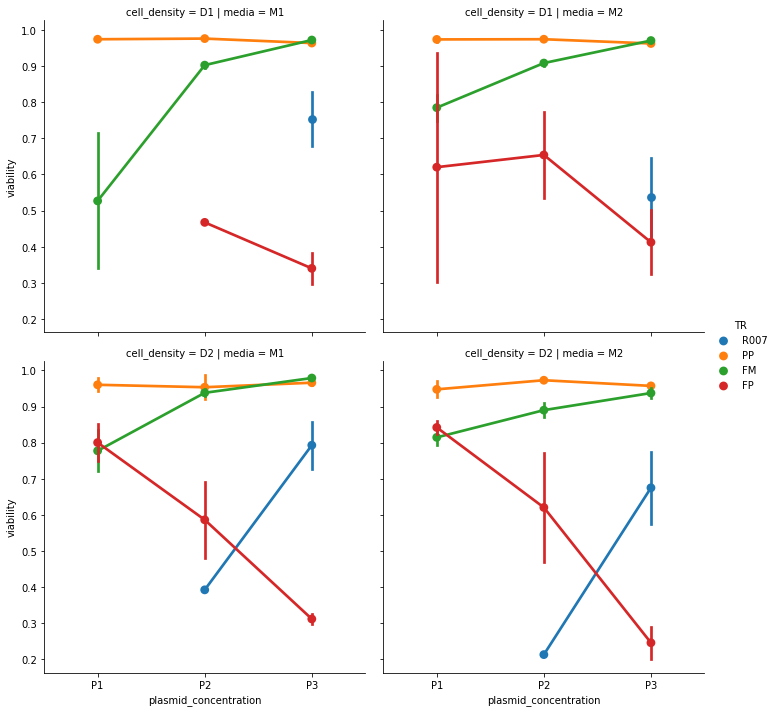

In [91]:
sns.catplot(data=long_form, x='plasmid_concentration', y='viability', hue='TR', row='cell_density', col='media', ci='sd', n_boot=1000, kind='point',order=['P1', 'P2', 'P3'])

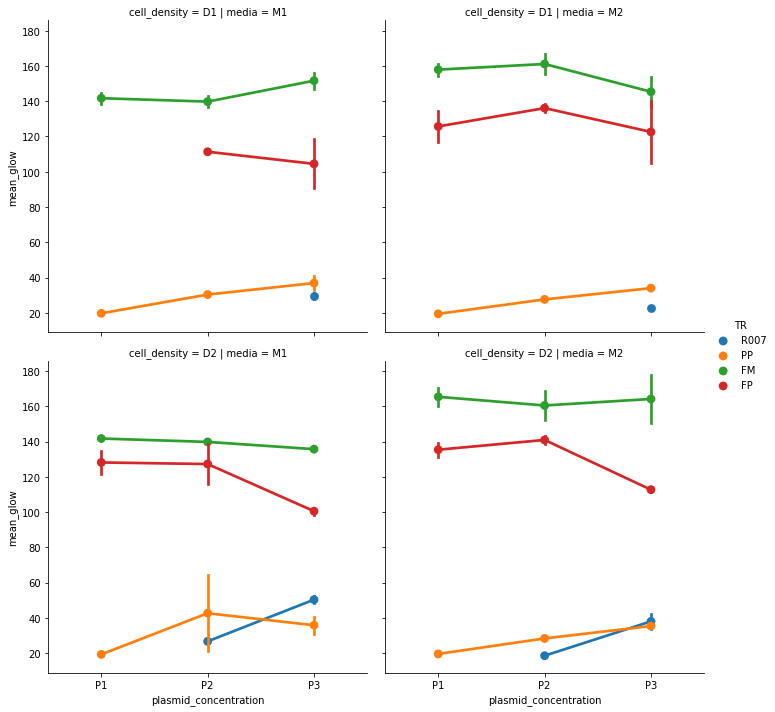

In [92]:
# you cant compare between plates due to the difference in machine settings

sns.catplot(data=long_form, x='plasmid_concentration', y='mean_glow', hue='TR', row='cell_density', col='media', ci='sd', n_boot=1000, kind='point', order=['P1', 'P2', 'P3'])

In [93]:
# PeiPRO is looking pretty good

In [111]:
#Final goal is having a maximum amount of product
#That is basically the same as maximum number of transfected cells
#So TransfectionEfficiency * Viability * CellNumber is probably a good proxy
#I dont think the cell count in the wells are valid. It looks a bit random. So I'm using the seeded amount of cells
cells_per_well = pd.DataFrame([
    {'reagent': 'R007', 'dens': 'D1', 'cpw': 150000},
    {'reagent': 'R007', 'dens': 'D2', 'cpw': 300000},
    {'reagent': 'FM', 'dens': 'D1', 'cpw': 206730},
    {'reagent': 'FM', 'dens': 'D2', 'cpw': 413461},
    {'reagent': 'PP', 'dens': 'D1', 'cpw': 390909},
    {'reagent': 'PP', 'dens': 'D2', 'cpw': 781818},
    {'reagent': 'FP', 'dens': 'D1', 'cpw': 387000},
    {'reagent': 'FP', 'dens': 'D2', 'cpw': 774000},
])
cells_per_well

,cpw,dens,reagent
0,150000,D1,R007
1,300000,D2,R007
2,206730,D1,FM
3,413461,D2,FM
4,390909,D1,PP
5,781818,D2,PP
6,387000,D1,FP
7,774000,D2,FP


In [134]:
final_answer = []
dens = ['D1', 'D2']
pc = ['P1', 'P2', 'P3']
media = ['M1', 'M2']
reagent = ['R007', 'FM', 'FP', 'PP']
for d in dens:
    for p in pc:
        for m in media:
            for r in reagent:
                cpw = cells_per_well[(cells_per_well['dens'] == d) & (cells_per_well['reagent'] == r)]['cpw'].iloc[0]
                wells = long_form[(long_form['TR'] == r) & (long_form['cell_density'] == d) & (long_form['media'] == m) & (long_form['plasmid_concentration'] == p)]
                final_answer.append({'transfectedCells': wells['perc_trans'].mean()*wells['viability'].mean()*cpw, 'TR': r, 'cellD': d, 'media': m, 'plasmid': p})
final_answer = pd.DataFrame(final_answer)
final_answer = final_answer.dropna()
final_answer.head()

,TR,cellD,media,plasmid,transfectedCells
1,FM,D1,M1,P1,26920.381904
3,PP,D1,M1,P1,9842.688010
5,FM,D1,M2,P1,36693.645318
6,FP,D1,M2,P1,38768.625438
7,PP,D1,M2,P1,9552.273763


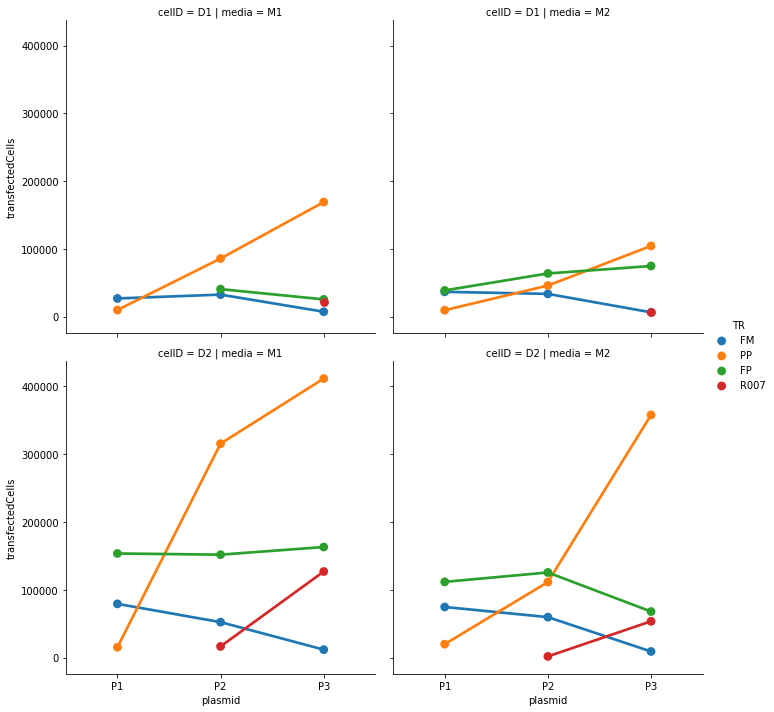

In [135]:
sns.catplot(data=final_answer, x='plasmid', y='transfectedCells', hue='TR', row='cellD', col='media', ci='sd', n_boot=1000, kind='point', order=['P1', 'P2', 'P3'])

In [138]:
final_answer.groupby('TR').max()['transfectedCells']

TR
FM       79185.896669
FP      163023.267846
PP      411463.875891
R007    126886.091358
Name: transfectedCells, dtype: float64